In [1]:
import pandas as pd
import numpy as np
import scipy.fftpack as spf
import seaborn as sns
import glob as gb
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import sys
import os

In [2]:
# センサデータ取得
def read_df(path):
    df = pd.read_csv(path)
    return df

# Timeから時間の差を追加
def differ_time(df):
    # Timeから時間の差を割り当てる
    df['dif_sec'] = df['time'].diff().fillna(0)
    df['cum_sec'] = df['dif_sec'].cumsum()
    return df

# 正規化
def minxmax_scaler(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    # 正規化したデータを新規のデータフレームに
    df_mc = pd.DataFrame(scaler.transform(df), columns=df.columns) 
    # 正規化したデータをリストに
    # mc_list = scaler.fit_transform(df)
    return df_mc

def split_part_recurrent_data(data_list, window):
    data_vec = []
    for i in range(len(data_list)-window+1):
        data_vec.append(data_list[i:i+window])
    
    # 部分時系列のサイズ確認
    # print(pd.DataFrame(data_vec).shape)
    # 部分時系列の一部を表示
    # print(pd.DataFrame(data_vec))
    return data_vec

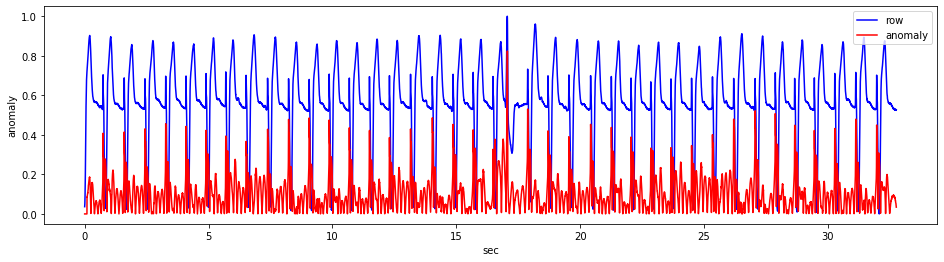

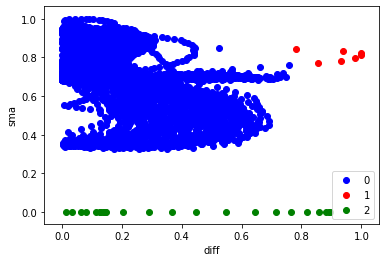

In [26]:
# # ブログ掲載用

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler

# # データ読み込み
# df = read_df('./ecg.csv')
# dif_df = differ_time(df) # 秒数を計算 
# test_df = dif_df.iloc[0:8192, :] # 使うデータだけ抽出

# N = len(test_df) # FFTのサンプル数 
# dt = 0.004 # サンプリング周波数 
# freq = np.fft.fftfreq(N, d=dt) # 周波数

# # 高速フーリエ変換(FFT)
# F = np.fft.fft(test_df['signal2'].values) 
# F_abs = np.abs(F/(N/2))

# # ローパスフィルタ
# threshold_period = 0.4
# threshold_freq = 1 / threshold_period
# F_lowpass = np.where(abs(freq) > threshold_freq, 0, F)
# lowpass = np.fft.ifftn(F_lowpass).real

# # 特徴量
# sma = test_df['signal2'].rolling(25).mean().fillna(0) # 0.1秒ごとの移動平均
# diff = abs(lowpass - test_df['signal2']) # ローパスフィルタとの差分

# # 結果をまとめるデータフレーム
# result_df = pd.DataFrame(diff, columns=['sma', 'diff', 'anomaly', 'label'])
# result_df['sma'] = sma
# result_df['diff'] = diff

#  # 異常度を正規化
# result_df = minxmax_scaler(result_df)

# # 移動平均とローパスフィルタとの差分を乗算
# result_df['anomaly'] = result_df['sma'] * result_df['diff'] 

# # ラベル振り
# result_df.loc[result_df['sma'] == 0, 'label'] = 2
# result_df.loc[result_df['anomaly'] > 0.6, 'label'] = 1
# result_df['label'] = result_df['label'].fillna(0)

# plt.figure(figsize=(16,4))
# plt.plot(test_df['cum_sec'], minxmax_scaler(test_df)['signal2'], color='blue', label='row')
# plt.plot(test_df['cum_sec'], result_df['anomaly'], color='red', label='anomaly')
# plt.legend()
# plt.xlabel('sec')
# plt.ylabel('anomaly')
# plt.show()

# c_list = ['blue', 'red', 'green']

# for i, c in enumerate(c_list):
#     plt.scatter(result_df.loc[result_df['label']==i, 'diff'], result_df.loc[result_df['label']==i, 'sma'], color=c, label=i)

# plt.xlabel('diff')
# plt.ylabel('sma')
# plt.legend()
# plt.show()

In [4]:
df = read_df('./ecg.csv')
display(df)
dif_df = differ_time(df)

time  signal1  signal2
0      200.000    4.770    2.100
1      200.004    4.820    2.135
2      200.008    4.805    2.190
3      200.012    4.750    2.285
4      200.016    4.710    2.440
...        ...      ...      ...
44995  379.980    4.860    5.070
44996  379.984    4.875    5.070
44997  379.988    4.880    5.085
44998  379.992    4.870    5.085
44999  379.996    4.890    5.115

[45000 rows x 3 columns]

7500


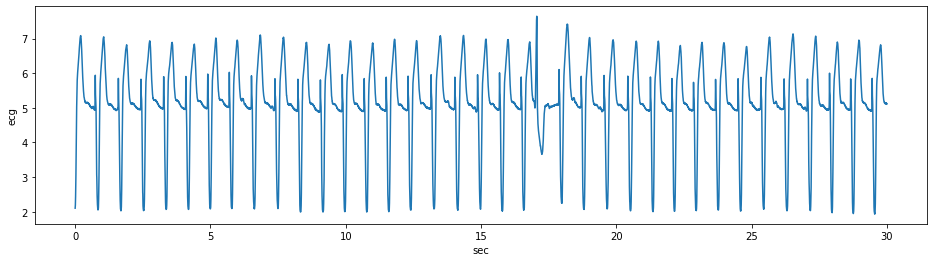

In [5]:
time_list = [0, 30, 60, 90, 120, 150, 180]
for t in range(len(time_list)-1):
    plt.figure(figsize=(16,4))  
    plt_df = dif_df.loc[(dif_df['cum_sec']>=time_list[t]) & (dif_df['cum_sec']<time_list[t+1])]
    print(len(plt_df))
    plt.plot(plt_df['cum_sec'], plt_df['signal2'])
    plt.xlabel('sec')
    plt.ylabel('ecg')
    plt.show()
    # plt.savefig('0-30.png')
    break

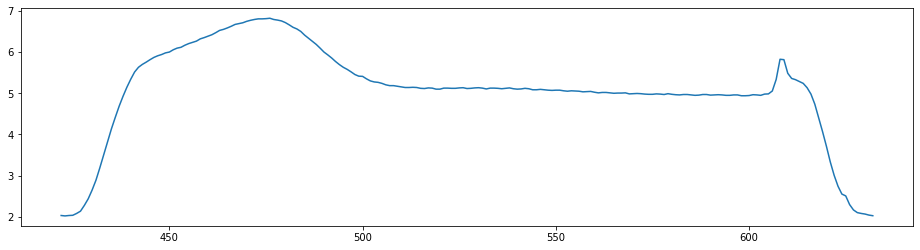

In [6]:
fft_df = dif_df.iloc[422:633, :]
# fft_df.style.bar()
plt.figure(figsize=(16,4))
plt.plot(fft_df['signal2'])
plt.show()

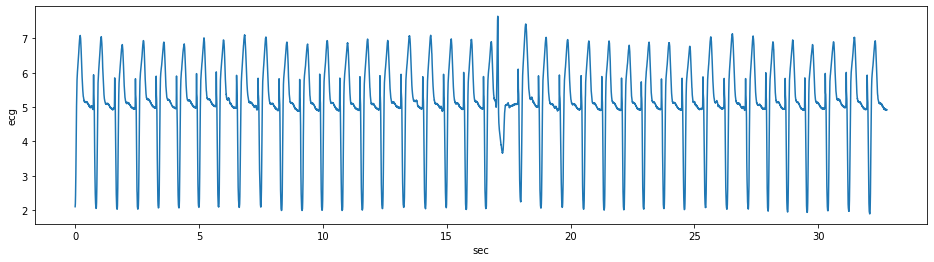

In [25]:
train_df = dif_df.iloc[0:3103, :]
test_df = dif_df.iloc[0:8192, :]

plt.figure(figsize=(16,4))
# plt.plot(train_df['signal2'], label='train')
plt.plot(test_df['cum_sec'], test_df['signal2'], label='test')
plt.xlabel('sec')
plt.ylabel('ecg')
plt.savefig('real data')
# plt.show()

(0, 10)

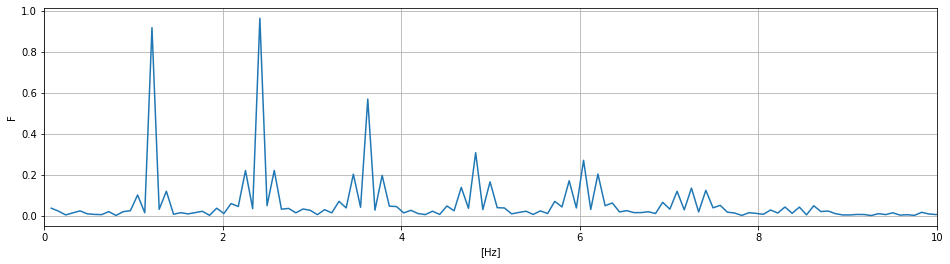

In [8]:
N = len(train_df) # FFTのサンプル数 
dt = 0.004 # サンプリング周波数 
freq = np.fft.fftfreq(N, d=dt) # 周波数

F = np.fft.fft(train_df['signal2'].values) # 高速フーリエ変換(FFT)
F_abs = np.abs(F/(N/2))
train_F_abs = F_abs[:int(N/2)]
train_F_mean = pd.Series(F).rolling(250).mean().fillna(0)

plt.figure(figsize=(16,4))
plt.plot(freq[1:int(N/2)], F_abs[1:int(N/2)])
plt.xlabel("[Hz]")
plt.ylabel("F")
plt.grid(True)
plt.xlim([0,10])

(0, 10)

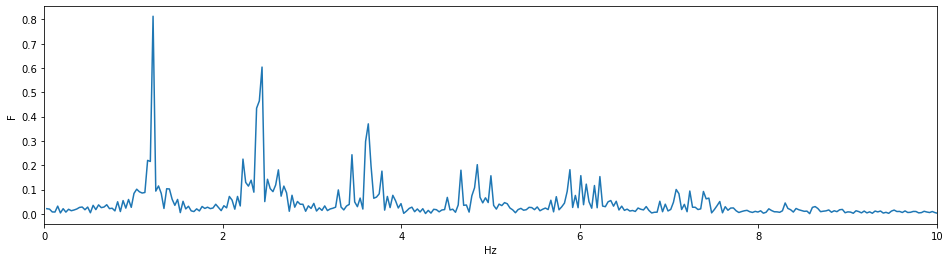

In [9]:
test_df = test_df.reset_index(drop=True)

N = len(test_df) # FFTのサンプル数 
dt = 0.004 # サンプリング周波数 
freq = np.fft.fftfreq(N, d=dt) # 周波数

F = np.fft.fft(test_df['signal2'].values) # 高速フーリエ変換(FFT)
F_abs = np.abs(F/(N/2))
test_F_abs = F_abs[:int(N/2)]
test_F_mean = pd.Series(F_abs).rolling(250).mean().fillna(0)

plt.figure(figsize=(16,4))
plt.plot(freq[1:int(N/2)], F_abs[1:int(N/2)])
plt.xlabel("Hz")
plt.ylabel("F")
plt.xlim([0,10])
# plt.savefig('fft.png')

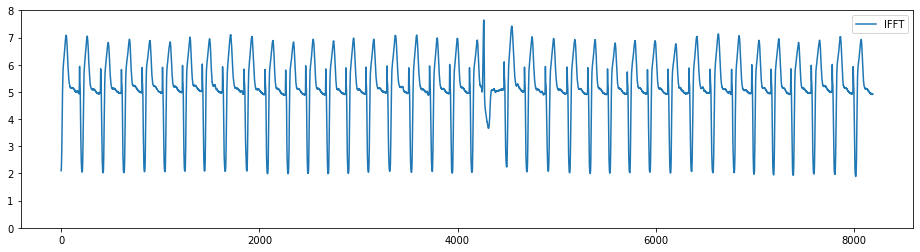

In [10]:
fig = plt.figure(figsize=(16, 4))
plt.plot(np.fft.ifftn(F).real, label='IFFT')
plt.legend()
plt.ylim(0,8)
plt.show()

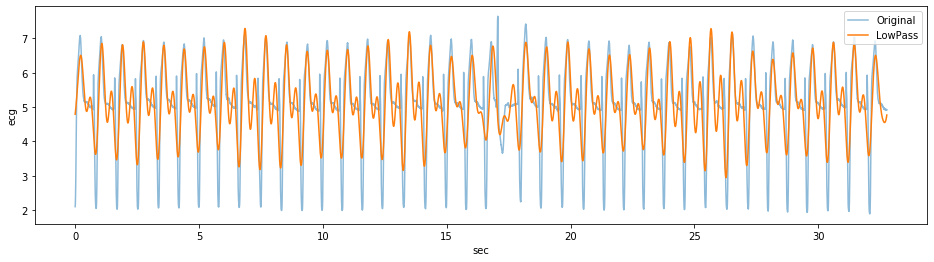

In [11]:
# 2以下の周期を無視する様な lowpass
threshold_period = 0.4
threshold_freq = 1 / threshold_period

z_lowpass = np.where(abs(freq) > threshold_freq, 0, F)
y_lowpass = np.fft.ifftn(z_lowpass).real

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(test_df['cum_sec'], test_df['signal2'], '-', label='Original', alpha=.5)
ax.plot(test_df['cum_sec'], y_lowpass, label='LowPass')
plt.xlabel('sec')
plt.ylabel('ecg')
ax.legend()

# plt.savefig('lowpass.png')
# plt.show()

(0, 10)

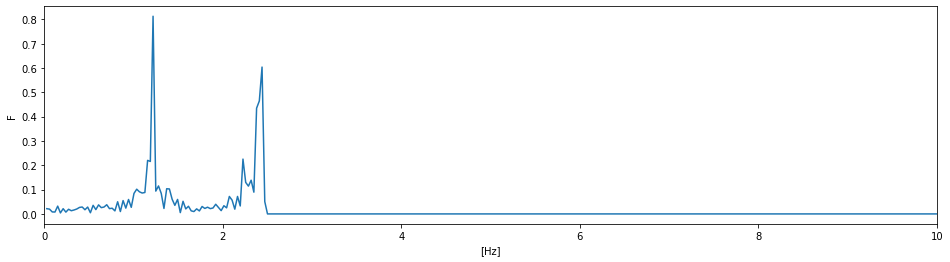

In [12]:
N = len(y_lowpass) # FFTのサンプル数 
dt = 0.004 # サンプリング周波数 
freq = np.fft.fftfreq(N, d=dt) # 周波数

F = np.fft.fft(y_lowpass) # 高速フーリエ変換(FFT)
F_abs = np.abs(F/(N/2))

plt.figure(figsize=(16,4))
plt.plot(freq[1:int(N/2)], F_abs[1:int(N/2)])
plt.xlabel("[Hz]")
plt.ylabel("F")
plt.xlim([0,10])
# plt.savefig('fft2.png')

Text(0, 0.5, 'sma')

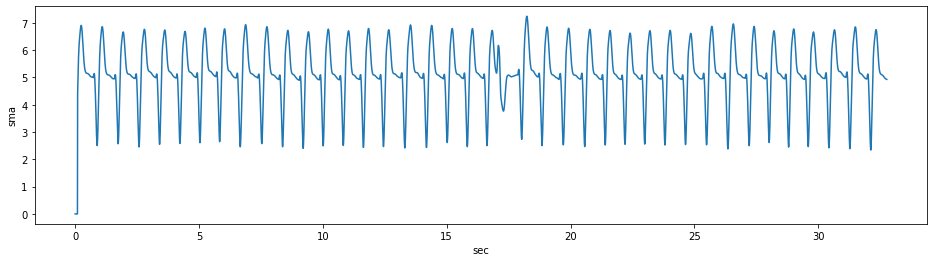

In [13]:
test_df_mean = test_df['signal2'].rolling(25).mean().fillna(0)
fig = plt.figure(figsize=(16, 4))
plt.plot(test_df['cum_sec'], test_df_mean)
plt.xlabel('sec')
plt.ylabel('sma')
# plt.savefig('sma.png')

Text(0, 0.5, 'lowpass anomaly')

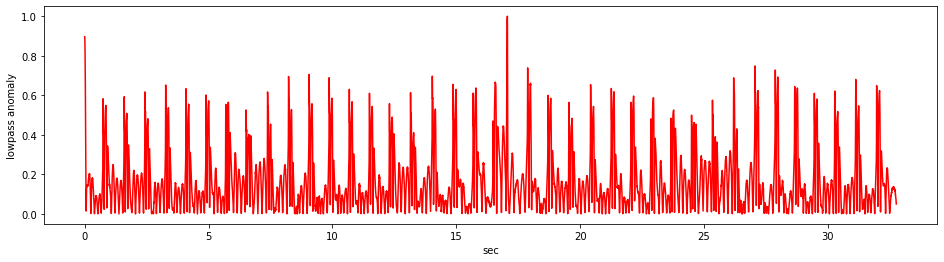

In [14]:
diff = abs(y_lowpass - test_df['signal2'])
fig = plt.figure(figsize=(16, 4))
plt.plot(test_df['cum_sec'], minxmax_scaler(pd.DataFrame(diff)), color='red', label='lowpass anomaly')
plt.xlabel('sec')
plt.ylabel('lowpass anomaly')
# plt.plot(minxmax_scaler(pd.DataFrame(test_df_mean)))
# plt.show()
# plt.savefig('lowpass anomaly.png')

In [15]:
result_df = pd.DataFrame(columns=['sma', 'diff', 'anomaly', 'label'])
result_df['sma'] = test_df_mean
result_df['diff'] = diff
result_df = minxmax_scaler(result_df)
result_df['anomaly'] = result_df['sma'] * result_df['diff']
result_df.loc[result_df['sma'] == 0, 'label'] = 2
result_df.loc[result_df['anomaly'] > 0.6, 'label'] = 1
result_df['label'] = result_df['label'].fillna(0)
display(result_df)

sma      diff   anomaly  label
0     0.000000  0.896691  0.000000    2.0
1     0.000000  0.892807  0.000000    2.0
2     0.000000  0.882654  0.000000    2.0
3     0.000000  0.859568  0.000000    2.0
4     0.000000  0.816881  0.000000    2.0
...        ...       ...       ...    ...
8187  0.681318  0.079169  0.053939    0.0
8188  0.681125  0.071685  0.048826    0.0
8189  0.680959  0.058816  0.040052    0.0
8190  0.680793  0.055554  0.037821    0.0
8191  0.680572  0.050233  0.034187    0.0

[8192 rows x 4 columns]

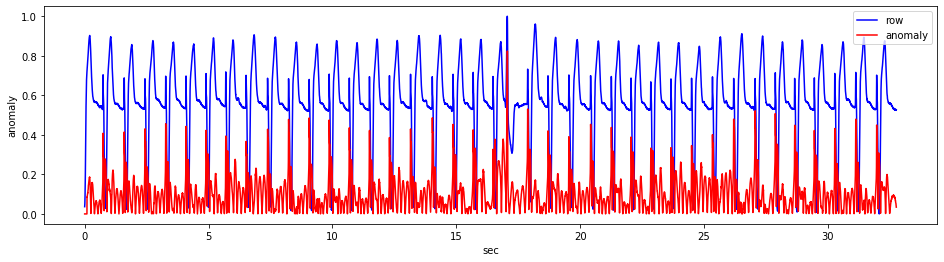

In [16]:
plt.figure(figsize=(16,4))

plt.plot(test_df['cum_sec'], minxmax_scaler(test_df)['signal2'], color='blue', label='row')
plt.plot(test_df['cum_sec'], result_df['anomaly'], color='red', label='anomaly')
# plt.plot(result_df['signal2'])
plt.legend()
plt.xlabel('sec')
plt.ylabel('anomaly')
plt.savefig('anomaly.png')

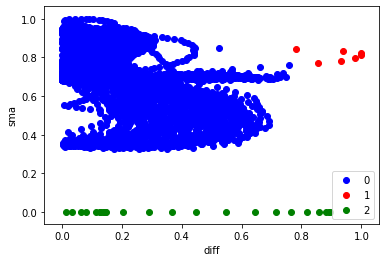

In [17]:
c_list = ['blue', 'red', 'green']

for i, c in enumerate(c_list):
    plt.scatter(result_df.loc[result_df['label']==i, 'diff'], result_df.loc[result_df['label']==i, 'sma'], color=c, label=i)
plt.xlabel('diff')
plt.ylabel('sma')
plt.legend()
# plt.savefig('scatter.png')

In [18]:
train_vec = split_part_recurrent_data(train_df['signal2'].values, 550)
print(len(train_vec))
# for v in train_vec:
#     N = len(v) # FFTのサンプル数 
#     dt = 0.004 # サンプリング周波数 
#     freq = np.fft.fftfreq(N, d=dt) # 周波数

#     F = np.fft.fft(v) # 高速フーリエ変換(FFT)
#     F_abs = np.abs(F/(N/2))
#     plt.figure(figsize=(16,4))
#     plt.plot(freq[1:int(N/2)], F_abs[1:int(N/2)])
#     plt.xlabel("[Hz]")
#     plt.ylabel("F")
#     plt.grid(True)
#     plt.xlim([0,10])
#     plt.show()

2554


In [19]:
# test_vec = split_part_recurrent_data(test_df['signal2'].values, 422)
# print(len(test_vec))

# plt.figure(figsize=(16,4))
# for i, v in enumerate(train_vec):
#     N = len(v) # FFTのサンプル数 
#     dt = 0.004 # サンプリング周波数 
#     freq = np.fft.fftfreq(N, d=dt) # 周波数

#     F = np.fft.fft(v) # 高速フーリエ変換(FFT)
#     F_abs = np.abs(F/(N/2))

#     if i < 1055 or i > 1477:
#         plt.plot(freq[1:int(N/2)], F_abs[1:int(N/2)], color='blue', zorder=0, label='n')
#         pass
#     else:
#         plt.plot(freq[1:int(N/2)], F_abs[1:int(N/2)], color='red', zorder=1, label='an')
#         pass
#     plt.xlabel("[Hz]")
#     plt.ylabel("F")
#     plt.grid(True)
#     plt.xlim([0,10])
#     # plt.legend()
# plt.show()

(0, 3000)

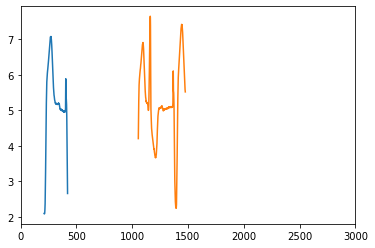

In [20]:
ex_df = dif_df.iloc[3103:6144, :]
ex_df = ex_df.reset_index(drop=True)

n_df = ex_df.iloc[211:422, :]
an_df = ex_df.iloc[1055:1477, :]
plt.plot(n_df['signal2'])
plt.plot(an_df['signal2'])
plt.xlim(0, 3000)

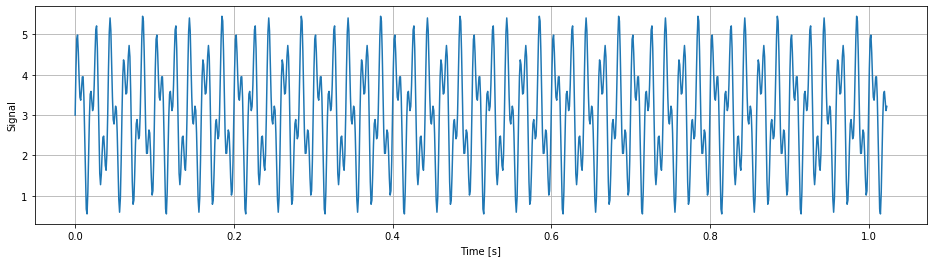

In [21]:
N = 1024            # サンプル数
dt = 0.001          # サンプリング周期 [s]
f1, f2 = 50, 120    # 周波数 [Hz]

t = np.arange(0, N*dt, dt) # 時間 [s]
x = 1.5*np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + 3 # 信号

plt.figure(figsize=(16,4))
plt.plot(t, x)
# ax.set_xlim(0, 0.1)
plt.xlabel("Time [s]")
plt.ylabel("Signal")
plt.grid()
plt.show()

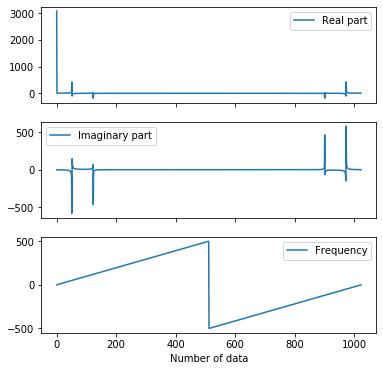

In [22]:
F = np.fft.fft(x) # 変換結果
freq = np.fft.fftfreq(N, d=dt) # 周波数

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6,6))
ax[0].plot(F.real, label="Real part")
ax[0].legend()
ax[1].plot(F.imag, label="Imaginary part")
ax[1].legend()
ax[2].plot(freq, label="Frequency")
ax[2].legend()
ax[2].set_xlabel("Number of data")
plt.show()

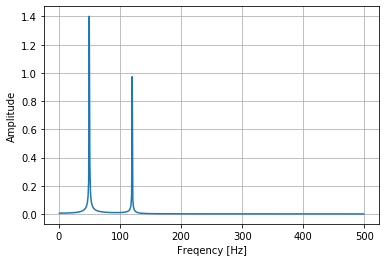

In [23]:
Amp = np.abs(F/(N/2)) # 振幅

fig, ax = plt.subplots()
ax.plot(freq[1:int(N/2)], Amp[1:int(N/2)])
ax.set_xlabel("Freqency [Hz]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.show()